In [1]:
import pandas as pd
import geopandas as gp
import os
import numpy as np
import matplotlib
import fiona
import pathlib
import glob
import rasterstats

In [ ]:
#### SET FILE PATHS ####

boundary_path = "/home/nweiss/gdrive/Year 2/Summer - Duwamish/GIS/Boundary/SP clipping area.shp"
clip_path = "/home/nweiss/gdrive/Year 2/Summer - Duwamish/GIS/Clipped"
raw_path = "/home/nweiss/gdrive/Year 2/Summer - Duwamish/GIS/Raw"
project_path = "/home/nweiss/gdrive/Year 2/Summer - Duwamish/GIS/Projected"

In [ ]:
# set project CRS
crs = 2926

# set boundary
boundary = gp.read_file(boundary_path)
boundary_project = boundary.to_crs(crs)
boundary_project.to_file(boundary_path)

In [ ]:
# project to project's crs and clip to boundary

files = glob.glob(raw_path + '/**/*.shp', recursive = True)

for f in files:
    file_name = os.path.basename(f)[:-4]
    print(f'processing {file_name}')
    gdf = gp.read_file(f)
    gdf_project = gdf.to_crs(crs)
    gdf_project.to_file(os.path.join(project_path, f'{file_name}_projected.shp'))
    print(os.path.join(project_path, f'{file_name}_projected.shp'))

    gdf_clip = gp.clip(gdf_project, boundary)
    gdf_clip.to_file(os.path.join(clip_path, f'{file_name}_clipped.shp'))
    print(os.path.join(clip_path, f'{file_name}_clipped.shp'))


CONTOUR PROCESSING

In [ ]:
# grab all 20' contours

# clip to extent

# grab all 5' contours that are within a 5 distance of the river boundary (do by hand)

STREET ANALYSIS

In [ ]:
# find average street width by functional class
#### TODO should this be within our zone or across the whole data set?
#### TODO change file path to one just processed

streets = gp.read_file("/home/nweiss/gdrive/Year 2/Summer - Duwamish/GIS/Raw/Seattle_Streets/Seattle_Streets.shp")
streets = streets.to_crs(crs)


In [ ]:
## check how many streets are missing width values
#streets.SURFACEWID.value_counts()
#print('number of roads with no width: ', len(streets[streets.SURFACEWID == 0]))

streets['ARTCLASS'] = streets['ARTCLASS'].map(str)

## backfill data by average width for each functional class
# remove rows = 0 before finding average
streets_wid = streets[['ARTCLASS','SURFACEWID']]
streets_wid = streets_wid[streets_wid.SURFACEWID != 0]
streets_wid.SURFACEWID.value_counts()

## calculate average by arterial class and surface type
streets_wid_avg = streets_wid.groupby(['ARTCLASS']).mean()
streets_wid_avg.reset_index(inplace = True)
streets_wid_avg['ARTCLASS'] = streets_wid_avg['ARTCLASS'].map(str).str[0]

## histogram of artclass = 0 surface width
# IQR of not designated roads with a surface width ranges from 22-25. min = 8 and max = 84
#streets[streets['ARTCLASS']=='0.0'][streets['SURFACEWID']!= 0]['SURFACEWID'].describe()

In [ ]:
# bring in and process clipped data
#### TODO change file path
streets_clipped = "/home/nweiss/gdrive/Year 2/Summer - Duwamish/GIS/Projected/seattle_streets_clipped_projected.shp"

streets_clipped_gdf = gp.read_file(streets_clipped)
streets_clipped_gdf = streets_clipped_gdf.to_crs(crs)
streets_clipped_gdf['ARTCLASS'] = streets_clipped_gdf['ARTCLASS'].map(str)


In [ ]:
# backfill data in the CLIPPED AND PROJECTED FILE by average width for each functional class
# NOTE: arterial class == 9 has one feature with surface width == 0. there is no backfilled data for this road
streets_bfill = pd.merge(left = streets_clipped_gdf, right = streets_wid_avg, how = 'left', left_on = 'ARTCLASS', right_on = 'ARTCLASS')
streets_bfill[['OBJECTID','ARTCLASS','UNITDESC','ARTDESCRIP','SURFACEWID_x','SURFACEWID_y','geometry']]
streets_bfill['width_upd'] = np.where(streets_bfill['SURFACEWID_x'] == 0, streets_bfill['SURFACEWID_y'], streets_bfill['SURFACEWID_x'])

In [ ]:
# buffer by the surface width
streets_bfill['geometry'] = streets_bfill.buffer(distance = streets_bfill['width_upd'])
columns = ['OBJECTID','ARTCLASS','UNITDESC','STNAME_ORD','ARTDESCRIP','SURFACEWID_x','width_upd','geometry']


In [ ]:
# output buffers as polygons and as outline polylines
streets_bfill[columns].to_file("/home/nweiss/gdrive/Year 2/Summer - Duwamish/GIS/Processed/seattle_streets_buffer.shp")
streets_bfill.dissolve().boundary.to_file("/home/nweiss/gdrive/Year 2/Summer - Duwamish/GIS/Processed/seattle_streets_buffer_outlines.shp")

In [ ]:
## looking at SND network to compare against seattle streets
SND = gp.read_file("/home/nweiss/gdrive/Year 2/Summer - Duwamish/GIS/Raw/Street_Network_Database_(SND)-20230505T014240Z-001/Street_Network_Database_(SND)/Street_Network_Database_(SND).shp")

In [ ]:
# TODO: need to look up what the arterial class widths are
SND.columns
SND['ARTERIAL_C'].value_counts()

BUILDING ANALYSIS

In [2]:
#### TODO UPDATE TO THE MORE RECENT FILE (https://seattlecitygis.maps.arcgis.com/home/item.html?id=c7265e8e78f14970bf375d9b2259e82a)

buildings = gp.read_file("/home/nweiss/gdrive/Year 2/Summer - Duwamish/GIS/Projected/buildings_2015_clipped_projected.shp")

In [3]:
## used topo to raster tool with 5ft contours and 5 ft pixel resolution
# there may be better ways to get DEM / elevation values as raster
topo_rast = "/home/nweiss/gdrive/Year 2/Summer - Duwamish/GIS/elevation_rast_5ft_cont.tif"

In [44]:
# find building height
# option 1: spatial join building centroid to nearest 5ft contour
# option 2: zonal statistic over raster for building footprint

test = buildings[:1000]
zonal_stats = rasterstats.zonal_stats(test, topo_rast, stats="count min mean max median std")
stats_df = pd.DataFrame.from_dict(zonal_stats).reset_index()
test.reset_index(inplace = True)

In [45]:
merged_heights = pd.merge(test, stats_df, how = 'left', left_on = 'index', right_on = 'index')

In [46]:
merged_heights['height_upd'] = (merged_heights['BP99_APEX']-merged_heights['mean']).astype(int)
merged_heights[['BP99_APEX','mean','min','max','median','std','height_upd']]

,BP99_APEX,mean,min,max,median,std,height_upd
0,81,-15.643722,-21.110571,-13.896954,-14.625418,1.962462,96
1,66,-17.753135,-19.431469,-15.849288,-17.612436,1.158415,83
2,67,-16.176445,-17.399797,-11.026821,-16.620689,1.340995,83
3,64,-18.839761,-20.673250,-16.524836,-19.055712,1.224284,82
4,333,319.810907,318.770691,321.426575,319.763428,0.548536,13
...,...,...,...,...,...,...,...
995,223,205.324419,201.509674,209.290298,205.050278,1.977568,17
996,275,248.877339,246.540436,250.444458,249.079468,0.982626,26
997,265,249.631660,247.140228,251.764267,249.980835,1.263988,15
998,260,236.834256,235.562592,238.720810,236.722687,0.770638,23


array([[<Axes: title={'center': 'std'}>]], dtype=object)

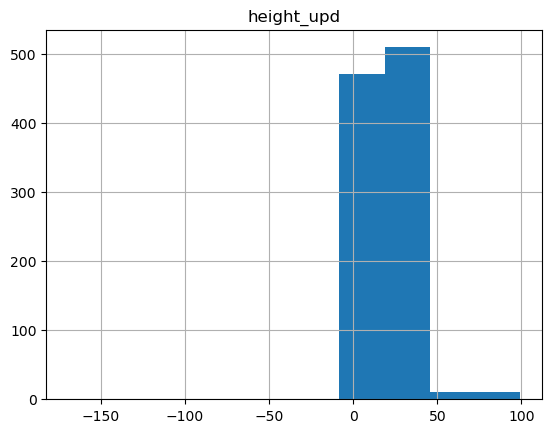

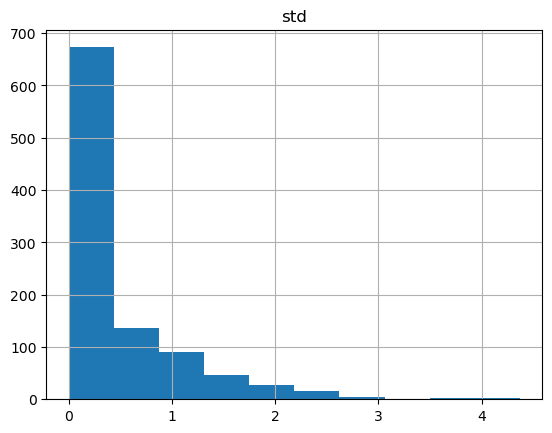

In [47]:
merged_heights.hist(column ='height_upd')
merged_heights.hist(column ='std') ## need to look at the ones with high std dev